/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


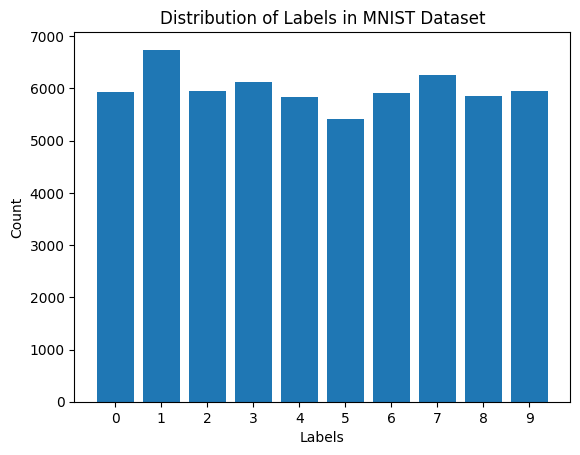

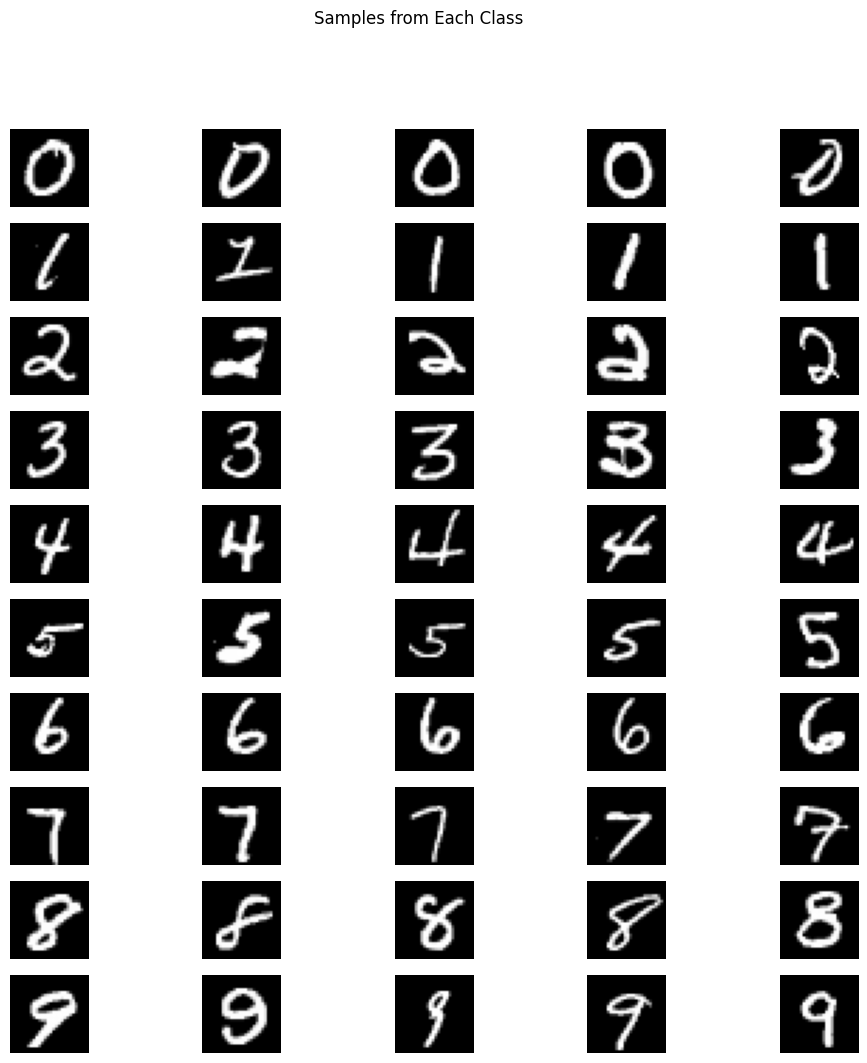

Class Imbalance:
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Step 2: Visualize the distribution of labels
def plot_label_distribution(dataloader):
    label_counts = [0] * 10
    for _, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1

    labels = [str(i) for i in range(10)]
    plt.bar(labels, label_counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in MNIST Dataset')
    plt.show()

plot_label_distribution(trainloader)

# Step 3: Visualize samples from each class
def visualize_samples(dataloader, num_samples=5):
    class_samples = {i: [] for i in range(10)}

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_samples:
                class_samples[label.item()].append(image)

    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))

    for i in range(10):
        for j in range(num_samples):
            axes[i, j].imshow(class_samples[i][j].squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Samples from Each Class')
    plt.show()

visualize_samples(trainloader)

# Step 4: Check for class imbalance
label_counts = [0] * 10
for _, labels in trainloader:
    for label in labels:
        label_counts[label.item()] += 1

print("Class Imbalance:")
for i, count in enumerate(label_counts):
    print(f"Class {i}: {count} samples")


# Step 6: Define a function to visualize feature maps (for a given layer)
def visualize_feature_maps(model, dataloader, layer_idx):
    model.eval()
    images, _ = next(iter(dataloader))
    feature_maps = model.features(images)
    selected_feature_map = feature_maps[0, layer_idx]

    plt.figure(figsize=(8, 8))
    plt.imshow(selected_feature_map.detach().cpu(), cmap='viridis')
    plt.title(f'Feature Map {layer_idx}')
    plt.axis('off')
    plt.show()

# You'll need to have a trained CNN model for this step.
# Replace 'model' with your trained model and specify the layer index.

# Example:
# visualize_feature_maps(model, valloader, layer_idx)



In [2]:
# Step 5: Partition the dataset into train, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)
# Create train and validation data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,generator=gen)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,generator=gen)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=strides,padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=strides,padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model with custom dropout, strides, and kernel_size
model = CustomCNN(dropout_size=0.25, strides=2, kernel_size=3)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc

# Train the model
# train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# # Plot training and validation loss and accuracy
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_acc, label='Train Acc')
# plt.plot(val_acc, label='Val Acc')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()

# plt.show()

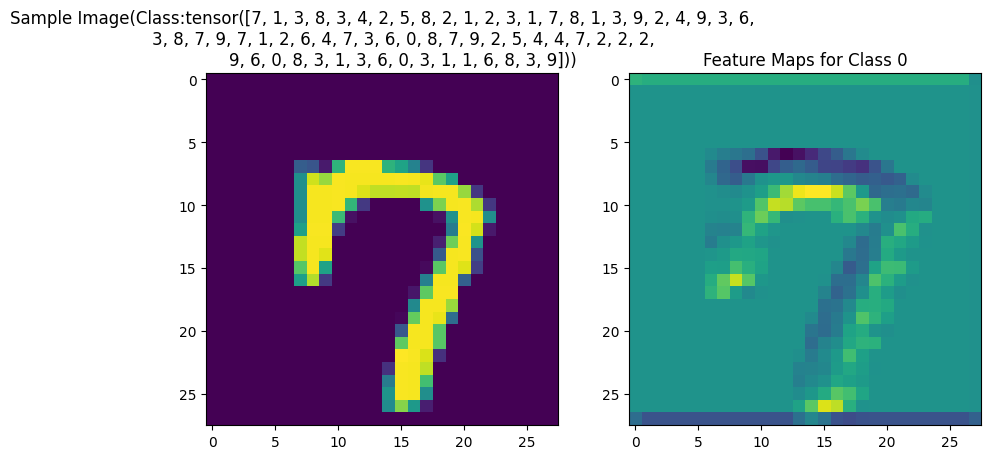

In [10]:
# Function to display feature maps
sample_loader = iter(val_loader)
sample_image, sample_label = next(sample_loader)

def display_feature_maps(class_id):
    # Get the activations from the first convolutional layer (conv1)
    activation = model.conv1(sample_image)
    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].permute(1, 2, 0).numpy())
    plt.title(f"Sample Image(Class:{sample_label})")
    # Display the feature maps
    plt.subplot(1, 2, 2)
    plt.imshow(activation[0,class_id].detach().numpy(), cmap='viridis')
    plt.title(f'Feature Maps for Class {class_id}')
    plt.show()

class_id = 0  # Change this to the desired class index
# Call the function to display the feature maps for the specified class
display_feature_maps(class_id)

In [5]:
import wandb
wandb.init(project="Convolution-Neural-Networks")
sweep_config = {
    "method": "random",
    "name": "hyperparameter-tuning",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.0001, 0.001]},
        "batch_size": {"values": [64, 128]},
        "kernel_size": {"values": [2, 3]},
        "strides": {"values": [1,2]},
        "num_epochs": {"values": [3,5]},
        "dropout_rate": {"values": [0.5, 0.7]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="Convolution-Neural-Networks")
def train():
    config = wandb.config
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    dropout_rate = config.dropout_rate
    kernel_size = config.kernel_size
    strides = config.strides
    num_epochs = config.num_epochs
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,generator=gen)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,generator=gen)
    model = CustomCNN(dropout_size=dropout_rate, strides=strides, kernel_size=kernel_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"Validation set Accuracy":val_acc[-1]})

# Run the sweep
wandb.agent(sweep_id, function=train)


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: uoe93buk
Sweep URL: https://wandb.ai/rohitgowlapalli01/Convolution-Neural-Networks/sweeps/uoe93buk
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: ldvudeop with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	strides: 1
Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_38949/1170231113.py", line 28, in train
UnboundLocalError: local variable 'model' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finish(exit_code=1)
  File "/home/rohit172/.local/lib/python3.8/site

Error in callback <function _WandbInit._pause_backend at 0x7ff73c1e5700> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe